# Durak Training Notebook with Live Plotting

This notebook demonstrates how to train your AlphaZero-like model for Durak while showing live updates of both training loss and evaluation win rate in real-time.

## Requirements
1. You must have the updated code in `src/model/trainer.py` that implements:
   - Reward shaping
   - Forced game-length limit
   - Mixed training vs. rule agent
   - Imitation learning methods (optional)
2. You must have a rule-based agent in `src/evaluation/rule_agent.py` and an evaluator in `src/evaluation/evaluator.py`.
3. This notebook will import and use those modules.
4. Install `matplotlib`, `ipywidgets`, and `ipython` if you want interactive plotting.

## Usage
You can run this entire notebook cell-by-cell. It will:
1. Import needed modules.
2. Optionally do imitation learning from a rule-based agent.
3. Run a custom training loop with dynamic plotting.

Let's begin!

In [1]:
%cd ../

# Set up environment
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch
import random

import pyspiel  # Make sure open_spiel is installed
from src.durak.durak_game import DurakGame
from src.model.network import AlphaZeroNet
from src.model.trainer import Trainer
from src.evaluation.evaluator import evaluate_model_vs_rule_agent
from src.evaluation.rule_agent import RuleAgent
from src.utils.checkpoint import load_checkpoint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/ivan/Projects/Neurodurak/AlphaZero-Durak
Using device: cuda


## Initialize the Game and Network

Here we create a bigger network (256 hidden dims, 4 layers) to match the advanced approach.
Adjust `hidden_dim`, `num_layers`, or other parameters as desired.

In [2]:
game = DurakGame()

use_history = True

if use_history:
    print("Using history-based network architecture")
    network = AlphaZeroNet(
        input_dim=158,      # from DurakObserver
        hidden_dim=256,     # bigger net
        num_actions=39,     # 36 cards + 3 extra actions
        num_layers=4,       # deeper
        use_history=True,   # Enable LSTM history
        history_dim=128     # Size of history embedding
    ).to(device)
else:
    # Original network
    network = AlphaZeroNet(
        input_dim=158,
        hidden_dim=256,
        num_actions=39,
        num_layers=4
    ).to(device)

# Load the checkpoint (adjust path as needed)
checkpoint_path = "checkpoints_old/130.ckpt"  # Change to your best checkpoint
game_count, _ = load_checkpoint(checkpoint_path, network, device=device)

# Create the advanced trainer with additional options
trainer = Trainer(
    network=network,
    game=game,
    device=device,
    learning_rate=1e-3,
    mcts_simulations=200,   # increased
    c_puct=1.5,             # higher exploration parameter
    temperature=1.0,
    use_argmax=False,
    take_cards_penalty=0.5,
    move_penalty=0.01,
    max_moves=40,
    forced_terminal_reward=-1.0,
    use_dirichlet=True,     # Enable Dirichlet noise for better exploration
    dirichlet_alpha=0.3,
    dirichlet_epsilon=0.25
)

Using history-based network architecture
Loaded checkpoint from checkpoints_old/130.ckpt


/home/ivan/Projects/Neurodurak/AlphaZero-Durak/src/utils/checkpoint.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_locatio

## Warm Start: Imitation Learning
Here we can train the model to imitate the rule agent for a certain number of games, e.g. 500 or 1000, to avoid fringe behaviors.

In [3]:
print("Generating rule agent dataset...")
dataset = trainer.generate_rule_agent_dataset_for_imitation(n_games=500)
print(f"Dataset size: {len(dataset)}")

print("Imitation learning from rule agent...")
trainer.train_supervised_on_rule_agent_dataset(dataset, batch_size=64, epochs=3)

Generating rule agent dataset...


Generating rule agent dataset: 100%|█████████| 500/500 [00:02<00:00, 233.64it/s]


Dataset size: 44017
Imitation learning from rule agent...
Epoch 1/3, Supervised Loss: 1.6257
Epoch 2/3, Supervised Loss: 1.4379
Epoch 3/3, Supervised Loss: 1.3178


## Live Training Loop With Dynamic Plotting
Below, we run a custom loop (similar to `run_training_with_mixed_opponents` or `run_training`) but in a manual Python `for` loop so we can update the plots after **each** iteration.

We'll:
1. Mix some fraction of games vs. the rule agent, and some self-play.
2. Collect training data, train in batches.
3. Evaluate vs. the rule agent.
4. Plot the results in real-time.

Note: The trainer now incorporates improved reward shaping so that winning actions are rewarded appropriately while moves like 'take cards' carry a heavier penalty.

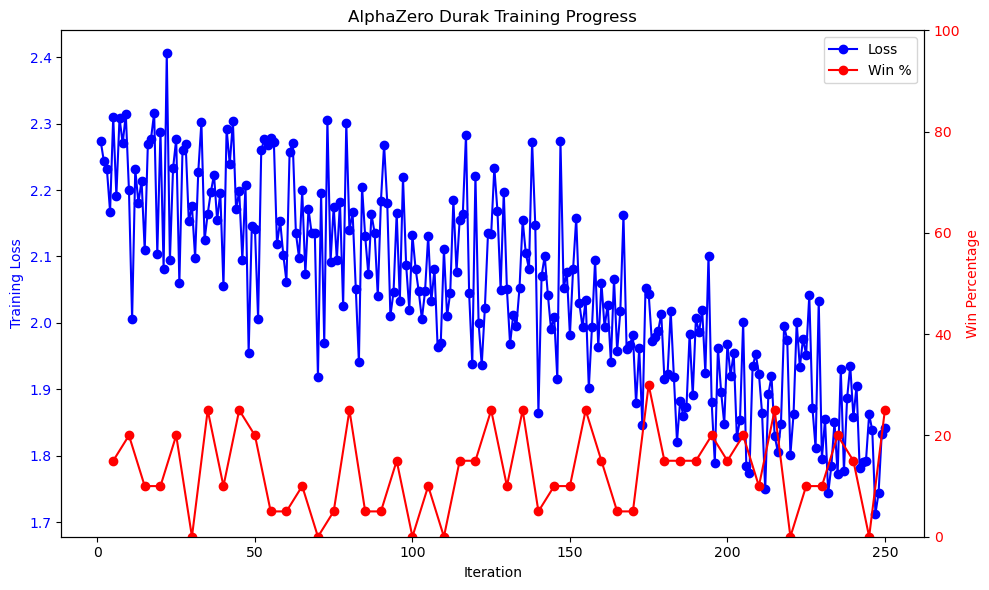

Saved checkpoint to checkpoint_reborn/2500.ckpt


In [3]:
# Hyperparameters for training
num_iterations = 250      # total training iterations
games_per_iteration = 10 # total games each iteration
fraction_vs_rule = 0.5   # fraction of games vs rule agent
batch_size = 32
eval_interval = 5        # evaluate every 5 iterations
eval_games = 20          # number of eval games vs. rule agent
model_player = 0         # model is player 0, rule agent is player 1

# Storage for plotting
loss_history = []
winrate_history = []
eval_iterations = []

for it in range(num_iterations):
    # 1) Gather training data
    iteration_data = []
    num_vs_rule = int(games_per_iteration * fraction_vs_rule)
    num_self = games_per_iteration - num_vs_rule

    # model vs rule agent
    for _ in range(num_vs_rule):
        data = trainer.play_vs_rule_agent(model_player=model_player)
        iteration_data.extend(data)

    # self-play
    for _ in range(num_self):
        data = trainer.self_play_game()
        iteration_data.extend(data)

    random.shuffle(iteration_data)

    # 2) Train
    losses = []
    for i in range(0, len(iteration_data), batch_size):
        batch = iteration_data[i:i+batch_size]
        loss_val, _, _ = trainer.train_step(batch)
        losses.append(loss_val)
    avg_loss = np.mean(losses) if losses else 0
    loss_history.append(avg_loss)

    # 3) Evaluate every eval_interval
    if (it+1) % eval_interval == 0:
        win_rate = evaluate_model_vs_rule_agent(
            network=trainer.network,
            device=trainer.device,
            num_games=eval_games,
            model_player=model_player,
            mcts_simulations=trainer.mcts_simulations,
            temperature=trainer.temperature,
            use_argmax=True  # deterministic for eval
        )
        winrate_history.append(win_rate)
        eval_iterations.append(it+1)
        print(f"Iteration {it+1}/{num_iterations}, Loss: {avg_loss:.4f}, Win vs rule: {win_rate*100:.1f}%")
    else:
        print(f"Iteration {it+1}/{num_iterations}, Loss: {avg_loss:.4f}")

    # 4) Live plot with combined loss and win rate on same figure
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss on left y-axis
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Training Loss', color='blue')
    ax1.plot(range(1, len(loss_history)+1), loss_history, 'bo-', label='Loss')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for win rate
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Win Percentage', color='red')
    if winrate_history:  # Only plot if we have data
        ax2.plot(eval_iterations, [w*100 for w in winrate_history], 'ro-', label='Win %')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 100)  # 0-100%

    # Add a title
    plt.title('AlphaZero Durak Training Progress')

    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.tight_layout()
    plt.show()

    # 5) Save checkpoint
    from src.utils.checkpoint import save_checkpoint
    save_checkpoint(trainer.network, trainer.game_count, checkpoint_dir="checkpoint_reborn")

## Results
When training completes, the final plots remain displayed in the last cell. You can also re-plot them by referencing `loss_history`, `winrate_history`, and `eval_iterations`.

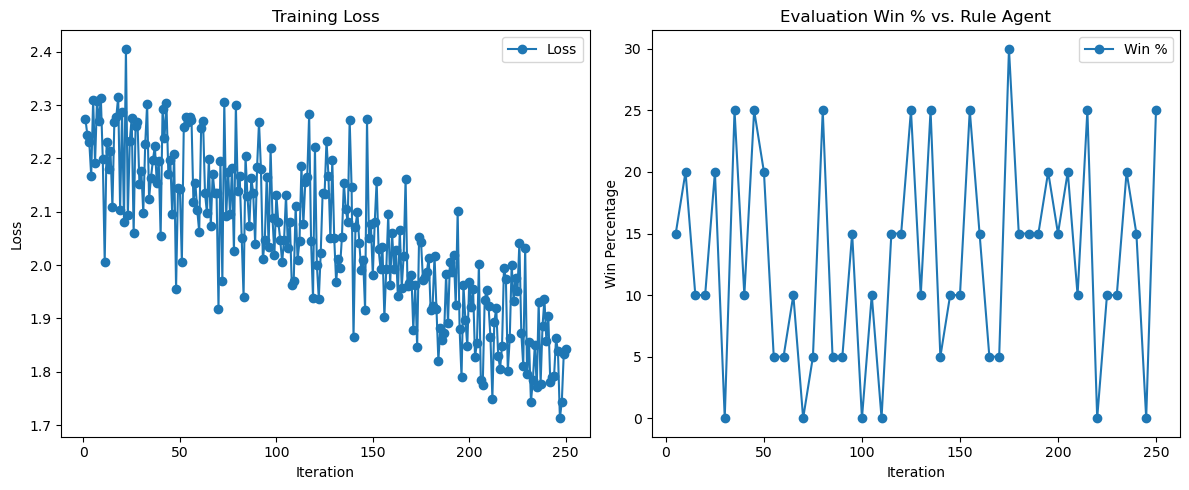

In [4]:
# If you want to plot them again:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o', label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
if winrate_history:
    plt.plot(eval_iterations, [w*100 for w in winrate_history], marker='o', label='Win %')
plt.xlabel('Iteration')
plt.ylabel('Win Percentage')
plt.title('Evaluation Win % vs. Rule Agent')
plt.legend()

plt.tight_layout()
plt.show()